# Cora dataset （2016）
+ 论文引用数据集 每个点有1433维向量
+ 最终要对每个点进行7分类任务（每个类别只有20个点有标注）

In [7]:
from torch_geometric.datasets import Planetoid # 下载数据集用的
from torch_geometric.transforms import NormalizeFeatures

# transform预处理
dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

print(f'Dataset: {dataset}')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0] # Get the first graph object.

print(data)

# Gather some statistics about the graph.

print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of taining nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Dataset: Cora()
Number of graphs: 1
Number of features: 1433
Number of classes: 7
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of taining nodes: 140
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [21]:
# 可视化部分

%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())
    
    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])
    
    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

## 用MLP做，效果如何？

In [11]:
import torch
from torch.nn import Linear
import torch.nn.functional as F

class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.lin1 = Linear(dataset.num_features, hidden_channels)
        self. lin2 = Linear(hidden_channels, dataset.num_classes)
    
    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x

model = MLP(hidden_channels=16)
print(model)

MLP(
  (lin1): Linear(in_features=1433, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=7, bias=True)
)


In [36]:
model = MLP(hidden_channels=16)
criterion = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

def train():
    model.train()
    opt.zero_grad()
    out = model(data.x)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    opt.step()
    return loss

def test():
    model.eval()
    out = model(data.x)
    pred = out.argmax(dim=1)
    test_correct = pred[data.test_mask] == data.y[data.test_mask]
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
    return test_acc

for epoch in range(1, 201):
    loss = train()
    print(f'Epoc: {epoch:03d}, Loss: {loss:.4f}')

Epoc: 001, Loss: 1.9552
Epoc: 002, Loss: 1.9509
Epoc: 003, Loss: 1.9459
Epoc: 004, Loss: 1.9390
Epoc: 005, Loss: 1.9315
Epoc: 006, Loss: 1.9266
Epoc: 007, Loss: 1.9167
Epoc: 008, Loss: 1.9103
Epoc: 009, Loss: 1.9003
Epoc: 010, Loss: 1.8866
Epoc: 011, Loss: 1.8755
Epoc: 012, Loss: 1.8613
Epoc: 013, Loss: 1.8502
Epoc: 014, Loss: 1.8348
Epoc: 015, Loss: 1.8370
Epoc: 016, Loss: 1.8141
Epoc: 017, Loss: 1.8030
Epoc: 018, Loss: 1.7941
Epoc: 019, Loss: 1.7639
Epoc: 020, Loss: 1.7534
Epoc: 021, Loss: 1.7284
Epoc: 022, Loss: 1.7197
Epoc: 023, Loss: 1.6978
Epoc: 024, Loss: 1.6924
Epoc: 025, Loss: 1.6291
Epoc: 026, Loss: 1.6481
Epoc: 027, Loss: 1.6158
Epoc: 028, Loss: 1.5767
Epoc: 029, Loss: 1.5934
Epoc: 030, Loss: 1.5142
Epoc: 031, Loss: 1.5181
Epoc: 032, Loss: 1.5279
Epoc: 033, Loss: 1.4700
Epoc: 034, Loss: 1.4390
Epoc: 035, Loss: 1.4200
Epoc: 036, Loss: 1.3847
Epoc: 037, Loss: 1.3456
Epoc: 038, Loss: 1.3639
Epoc: 039, Loss: 1.3490
Epoc: 040, Loss: 1.2532
Epoc: 041, Loss: 1.3210
Epoc: 042, Loss:

In [37]:
# 准确率计算

test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.5920


## GNN

In [19]:
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)
        
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


f:\anaconda3\envs\torch\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
f:\anaconda3\envs\torch\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


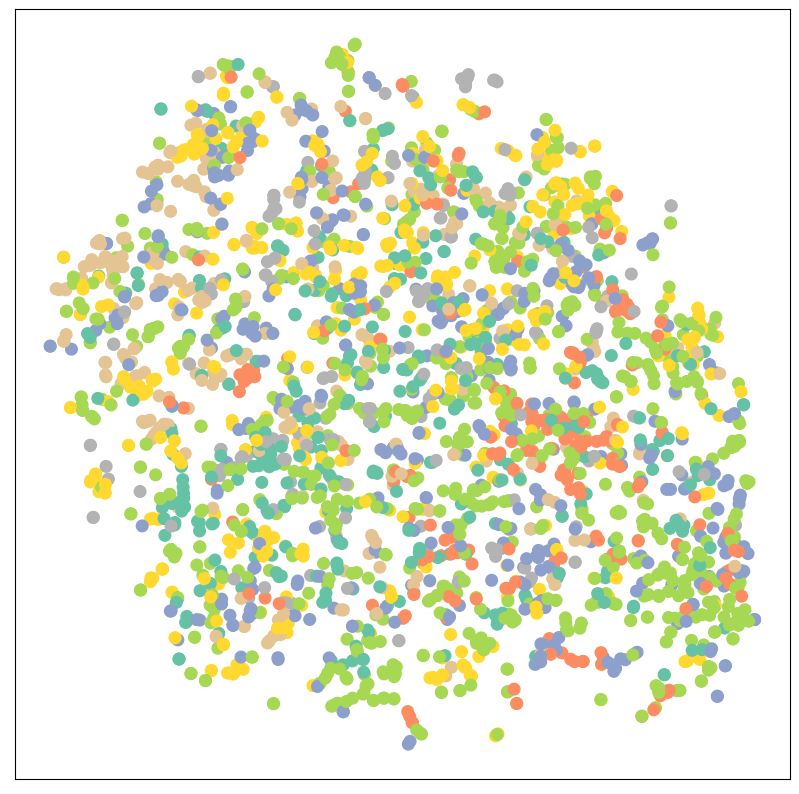

In [22]:
# 可视化时，由于输出是7维向量，所以降维成2维展示
model = GCN(hidden_channels=16)
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

In [27]:
model = GCN(hidden_channels=16)
criterion = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

def train():
    model.train()
    opt.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    opt.step()
    return loss

def test():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    test_correct = pred[data.test_mask] == data.y[data.test_mask]
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
    return test_acc

for epoch in range(1, 101):
    loss = train()
    print(f'Epoc: {epoch:03d}, Loss: {loss:.4f}')

Epoc: 001, Loss: 1.9463
Epoc: 002, Loss: 1.9409
Epoc: 003, Loss: 1.9343
Epoc: 004, Loss: 1.9275
Epoc: 005, Loss: 1.9181
Epoc: 006, Loss: 1.9086
Epoc: 007, Loss: 1.9015
Epoc: 008, Loss: 1.8933
Epoc: 009, Loss: 1.8808
Epoc: 010, Loss: 1.8685
Epoc: 011, Loss: 1.8598
Epoc: 012, Loss: 1.8482
Epoc: 013, Loss: 1.8290
Epoc: 014, Loss: 1.8233
Epoc: 015, Loss: 1.8057
Epoc: 016, Loss: 1.7966
Epoc: 017, Loss: 1.7825
Epoc: 018, Loss: 1.7617
Epoc: 019, Loss: 1.7491
Epoc: 020, Loss: 1.7310
Epoc: 021, Loss: 1.7147
Epoc: 022, Loss: 1.7056
Epoc: 023, Loss: 1.6954
Epoc: 024, Loss: 1.6697
Epoc: 025, Loss: 1.6538
Epoc: 026, Loss: 1.6312
Epoc: 027, Loss: 1.6161
Epoc: 028, Loss: 1.5899
Epoc: 029, Loss: 1.5711
Epoc: 030, Loss: 1.5576
Epoc: 031, Loss: 1.5393
Epoc: 032, Loss: 1.5137
Epoc: 033, Loss: 1.4948
Epoc: 034, Loss: 1.4913
Epoc: 035, Loss: 1.4698
Epoc: 036, Loss: 1.3998
Epoc: 037, Loss: 1.4041
Epoc: 038, Loss: 1.3761
Epoc: 039, Loss: 1.3631
Epoc: 040, Loss: 1.3258
Epoc: 041, Loss: 1.3030
Epoc: 042, Loss:

In [28]:
# 准确率计算

test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8150


f:\anaconda3\envs\torch\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
f:\anaconda3\envs\torch\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


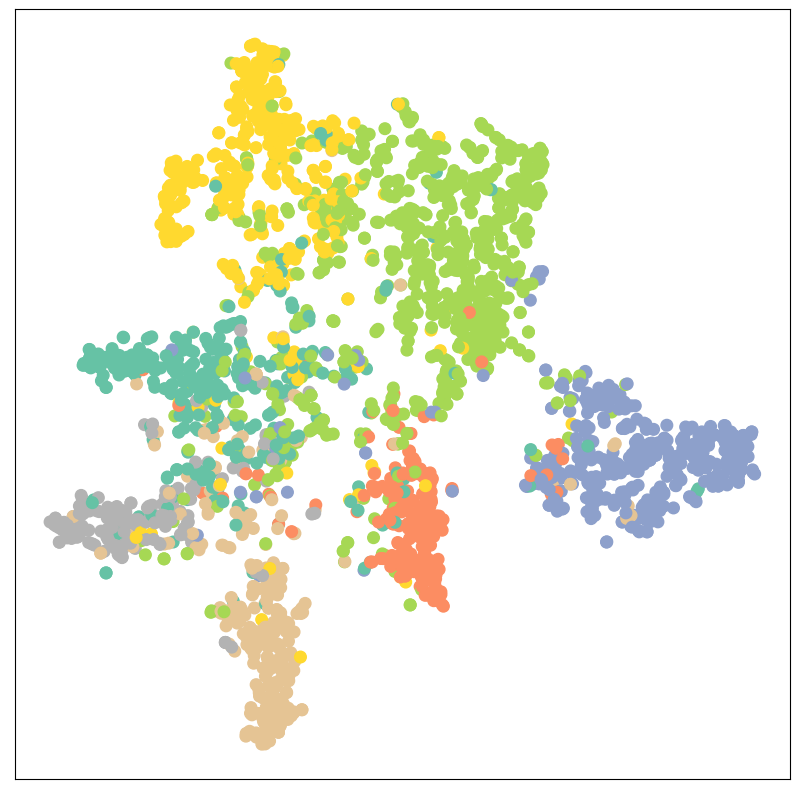

In [29]:
# 可视化时，由于输出是7维向量，所以降维成2维展示
model.eval()
out = model(data.x, data.edge_index)
visualize(out, color=data.y)